# Import Library

In [9]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
import imageio
import time
import warnings
warnings.filterwarnings("ignore")
import random
import sys
import random
import sys
import copy
import json
from PIL import Image
import imageio

# Read and Preprocess

In [10]:
data_dir = "flowers/"
train_dir = data_dir + "train/"
valid_dir = data_dir + "valid/"

# Data Source

In [11]:
data_transforms = {
    "train":
        transforms.Compose([
            transforms.Resize([96, 96]),  # Resize
            transforms.RandomRotation(45),
            transforms.CenterCrop(64),    # Get center
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            transforms.RandomGrayscale(p=0.025),  # Gray scale
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    "valid":
        transforms.Compose([
            transforms.Resize([64, 64]),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Same normalize
        ])
}

In [12]:
batch_size = 256

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid'] }
dataloader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

In [13]:
class_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [14]:
dataloader

{'train': <torch.utils.data.dataloader.DataLoader at 0x3222563a0>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x322256ca0>}

In [15]:
dataset_sizes

{'train': 3391, 'valid': 925}

# Load model

In [16]:
model_name= "resnet"
feature_extract = True

In [17]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

In [18]:
# GPU
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    if torch.backends.mps.is_available():
        print("Apple MLX")
    else:
        print("Training on CPU")
else:
    print("Cuda is available!")

device = get_default_device()

Apple MLX


In [19]:
model_ft = models.resnet152() # 101 152
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Update grad

In [20]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [21]:
for name, param in model_ft.named_parameters():
    print(name)
    print(param)

conv1.weight
Parameter containing:
tensor([[[[ 3.4599e-02,  3.0272e-02,  4.2174e-03,  ...,  1.8356e-02,
           -1.0473e-02,  1.3649e-02],
          [-5.8282e-03,  2.7717e-02,  1.5563e-02,  ...,  2.9845e-02,
           -1.0738e-02, -3.0014e-02],
          [-3.8926e-03,  2.4328e-03,  1.9620e-02,  ..., -2.1106e-03,
           -1.5378e-02,  1.3959e-02],
          ...,
          [ 1.3577e-02,  2.8391e-03, -3.2798e-02,  ...,  6.8774e-02,
            3.1830e-02,  4.3753e-02],
          [-5.5457e-02,  2.5163e-02, -1.1040e-02,  ..., -2.8600e-03,
            2.4017e-02,  1.4729e-02],
          [ 3.7477e-02, -3.8128e-04,  7.6664e-03,  ..., -1.0642e-03,
           -9.1415e-03, -1.2043e-02]],

         [[ 6.6016e-03,  1.0452e-02,  2.8153e-02,  ..., -1.3125e-02,
           -1.1808e-02,  1.1787e-02],
          [-3.6012e-02, -2.2773e-03, -6.1034e-02,  ..., -2.0216e-03,
            7.3258e-03, -2.0574e-02],
          [-2.3214e-02, -2.7146e-04,  5.1848e-03,  ..., -2.0610e-03,
            9.9956e-03,

In [22]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = models.resnet50(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)

    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, 5)

    input_size = 64

    return model_ft, input_size

# Set the layer we want to train

In [23]:
model_ft, input_size = initialize_model(model_name, 5, feature_extract, use_pretrained=True)

model_ft = model_ft.to(device)

filename = "best.pth"

params_to_update = model_ft.parameters()
print("Params to learn:")

if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad:
            params_to_update.append(param)
            print("\t", name)
else:
    for name, param in model_ft.named_parameters():
        if param.requires_grad:
            print("\t", name)

Params to learn:
	 fc.weight
	 fc.bias


# Optimizer

In [24]:
optimizer_ft = optim.Adam(params_to_update, lr=1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)  # Learning Rate
criterion = nn.CrossEntropyLoss()

In [25]:
optimizer_ft.param_groups[0]

{'params': [Parameter containing:
  tensor([[ 0.0175,  0.0180,  0.0120,  ...,  0.0163, -0.0200, -0.0059],
          [-0.0039,  0.0077,  0.0212,  ...,  0.0035,  0.0097, -0.0105],
          [-0.0028, -0.0121,  0.0077,  ...,  0.0077,  0.0204, -0.0071],
          [ 0.0005,  0.0168, -0.0160,  ...,  0.0032,  0.0121, -0.0165],
          [-0.0182,  0.0091,  0.0100,  ...,  0.0128,  0.0097,  0.0046]],
         device='mps:0', requires_grad=True),
  Parameter containing:
  tensor([-0.0077, -0.0121,  0.0217, -0.0140,  0.0209], device='mps:0',
         requires_grad=True)],
 'lr': 0.01,
 'betas': (0.9, 0.999),
 'eps': 1e-08,
 'weight_decay': 0,
 'amsgrad': False,
 'maximize': False,
 'foreach': None,
 'capturable': False,
 'differentiable': False,
 'fused': None,
 'initial_lr': 0.01}

In [26]:
def train_model(model, dataloaders,criterion, optimizer, num_epochs=20, filename='best.pth'):
    since = time.time()
    best_acc = 0
    model.to(device)
    # Print loss
    val_acc_history = []
    train_acc_history = []
    train_losses = []
    valid_losses = []

    # Learning Rate
    LRs = [optimizer.param_groups[0]['lr']]

    # Best model
    best_model_wts = copy.deepcopy(model.state_dict())

    # Iterate epoch
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch+1, num_epochs))
        print("=" * 10)

        # Train and validation
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Get all data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Set to zero
                optimizer.zero_grad()
                # Calc and update grad when training
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                # Update weight
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # Calc loss
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # 计算 epoch 的 loss 和 acc
            epoch_loss = running_loss / dataset_sizes[phase]
            # 使用 float32 计算 accuracy，兼容 MPS
            epoch_acc  = running_corrects.float() / dataset_sizes[phase]

            time_elapsed = time.time() - since
            if phase == 'valid':
                print("Time elapsed: {:.2f} seconds".format(time_elapsed))
                print("Loss: {:.4f}".format(epoch_loss))
                print("Accuracy: {:.4f}".format(epoch_acc))

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                state = {
                    'state_dict': model.state_dict(),
                    'best_acc': best_acc,
                    'optimizer': optimizer.state_dict(),
                }
                torch.save(state, filename)
            if phase == 'valid':
                val_acc_history.append(epoch_acc)
                valid_losses.append(epoch_loss)
            if phase == 'train':
                training_loss = epoch_loss
                training_acc = epoch_acc

        print("Optimizer learning rate: {:.4f}".format(optimizer.param_groups[0]['lr']))
        LRs.append(optimizer.param_groups[0]['lr'])
        print()
        scheduler.step()
        # Per epoch

    # Ends
    time_elapsed = time.time() - since
    print("Training complete in {:.2f} seconds".format(time_elapsed))
    print("Best val Acc: {:.4f}".format(best_acc))

    # Set the best result of the outcome of the model
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history, valid_losses, train_losses, LRs

# Training

In [ ]:
model_ft, val_acc_history, train_acc_history, valid_losses, train_losses, LRs = train_model(model_ft, dataloader, criterion, optimizer_ft, num_epochs=20, filename='best.pth')

## Resnet50:  0.6865

## Resnet152:  0.6908

# Keep training other layers

In [27]:
for param in model_ft.parameters():
    param.requires_grad = True

# Keep training, less lr
optimizer = optim.Adam(model_ft.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

criterion = nn.CrossEntropyLoss()

In [28]:
# Load trained wrights
checkpoint = torch.load(filename)
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [ ]:
model_ft, val_acc_history, train_acc_history, valid_losses, train_losses, LRs = train_model(model_ft, dataloader, criterion, optimizer_ft, num_epochs=280, filename='best.pth')

# Use model

In [29]:
model_ft, input_size = initialize_model(model_name, 5, feature_extract, use_pretrained=True)

# Gpu mode
model_ft = model_ft.to(device)

# Model
filename = "best.pth"

# Load model
checkpoint = torch.load(filename)
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

# Preprocess

In [30]:
dataiter = iter(dataloader['valid'])
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)


model_ft = model_ft.to(device)
model_ft.eval()

if train_on_gpu:
    output = model_ft(images.cuda())
else:
    output = model_ft(images)

In [31]:
output.shape

torch.Size([256, 5])

In [32]:
_, preds_tensor = torch.max(output, 1)

preds = preds_tensor.to("cpu").numpy().squeeze()
preds

array([3, 1, 2, 4, 1, 4, 3, 0, 4, 4, 4, 0, 4, 4, 1, 4, 1, 3, 2, 2, 2, 3,
       4, 4, 3, 4, 4, 1, 1, 2, 4, 4, 2, 1, 4, 3, 2, 1, 3, 2, 0, 4, 0, 2,
       4, 1, 3, 2, 4, 4, 3, 3, 1, 3, 4, 3, 4, 2, 3, 4, 4, 1, 3, 0, 0, 4,
       4, 2, 2, 0, 3, 0, 1, 4, 1, 3, 4, 4, 2, 0, 3, 0, 1, 2, 0, 3, 2, 0,
       0, 4, 1, 0, 0, 2, 3, 4, 4, 4, 3, 4, 4, 3, 4, 2, 2, 3, 4, 1, 3, 0,
       4, 1, 2, 1, 4, 3, 0, 1, 0, 3, 1, 0, 1, 4, 3, 3, 3, 1, 4, 4, 4, 2,
       1, 0, 1, 1, 4, 0, 2, 2, 3, 4, 2, 4, 0, 2, 4, 4, 0, 1, 1, 4, 3, 1,
       4, 1, 0, 1, 1, 3, 4, 2, 4, 1, 4, 1, 0, 3, 1, 1, 1, 0, 3, 1, 4, 2,
       4, 1, 4, 4, 4, 4, 1, 2, 4, 1, 4, 1, 3, 2, 3, 1, 1, 1, 3, 2, 0, 3,
       0, 1, 1, 1, 2, 2, 2, 1, 1, 4, 1, 1, 3, 3, 4, 1, 1, 2, 4, 2, 0, 4,
       4, 1, 2, 1, 3, 1, 4, 4, 4, 4, 4, 0, 1, 3, 2, 2, 3, 4, 1, 1, 3, 2,
       1, 1, 0, 1, 0, 1, 1, 0, 3, 1, 1, 1, 1, 4])

In [33]:
def im_convert(tensor):
    image = tensor.cpu().clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    image = image.clip(0, 1)

    return image

In [34]:
cat_to_name = {
    "0": "daisy",
    "1": "dandelion",
    "2": "rose",
    "3": "sunflower",
    "4": "tulip"
}

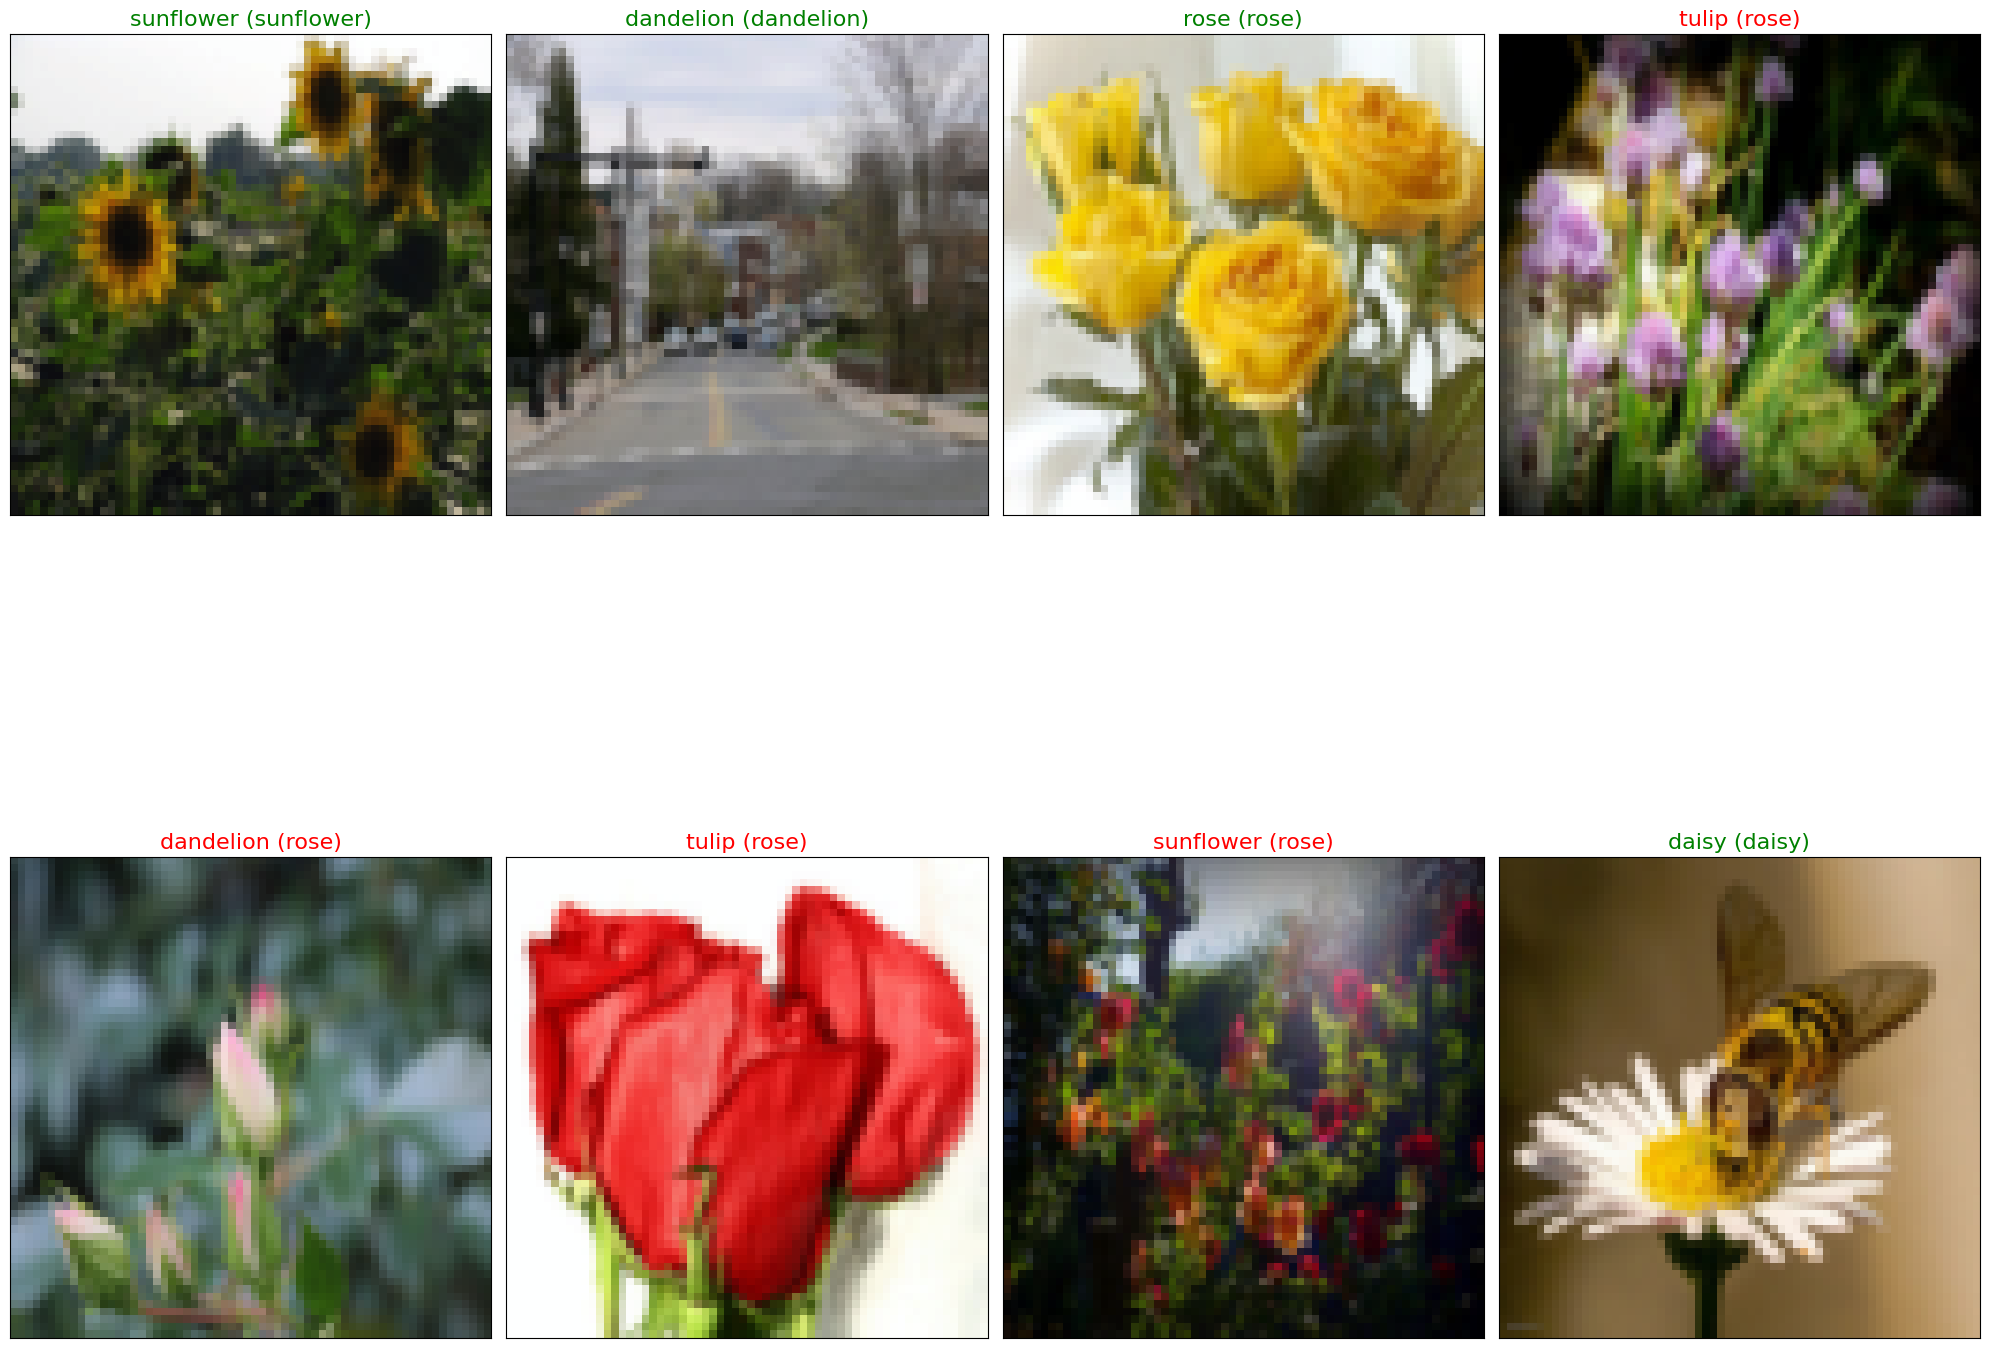

In [41]:
fig = plt.figure(figsize=(20, 20))
cols = 4
rows = 2

for idx in range(cols * rows):
    ax = fig.add_subplot(rows, cols, idx + 1, xticks=[], yticks=[])

    # Show image
    img = im_convert(images[idx])
    ax.imshow(img)

    # Pred and Truth
    pred_name = cat_to_name[str(preds[idx])]
    true_name = cat_to_name[str(labels[idx].item())]

    # Title
    title = f"{pred_name} ({true_name})"
    color = "green" if pred_name == true_name else "red"
    ax.set_title(title, color=color, fontsize=16)

plt.tight_layout()
plt.show()